In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("aadhaar_master_dataset.csv")
asi = pd.read_csv("aadhaar_asi_output (1).csv")

In [3]:
df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,age_18_greater,total_bio_updates,total_demo_updates,total_updates,total_enrolments,total_transactions
0,2025-03-01,Andaman And Nicobar Islands,Nicobar,744301,101.0,48.0,0.0,0.0,0.0,0.0,0.0,149.0,0.0,149.0,0.0,149.0
1,2025-04-01,Andaman And Nicobar Islands,Nicobar,744301,28.0,41.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,69.0,0.0,69.0
2,2025-05-01,Andaman And Nicobar Islands,Nicobar,744301,13.0,15.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,28.0,0.0,28.0
3,2025-06-01,Andaman And Nicobar Islands,Nicobar,744301,19.0,29.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,48.0,0.0,48.0
4,2025-07-01,Andaman And Nicobar Islands,Nicobar,744301,23.0,40.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,63.0,0.0,63.0


In [4]:
asi.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,...,api,rolling_avg_7d,svs,uif,ulr_n,api_n,svs_n,uif_n,asi_score,asi_risk
0,2025-03-01,Andaman And Nicobar Islands,Nicobar,744301,101.0,48.0,0.0,0.0,0.0,0.0,...,0.322148,149.0,1.000000,1.0,0.005758,0.322148,0.147157,1.0,31.905363,MEDIUM
1,2025-04-01,Andaman And Nicobar Islands,Nicobar,744301,28.0,41.0,0.0,0.0,0.0,0.0,...,0.594203,109.0,0.633028,1.0,0.002667,0.594203,0.093123,1.0,37.263141,MEDIUM
2,2025-05-01,Andaman And Nicobar Islands,Nicobar,744301,13.0,15.0,0.0,0.0,0.0,0.0,...,0.535714,82.0,0.341463,1.0,0.001082,0.535714,0.050192,1.0,34.680122,MEDIUM
3,2025-06-01,Andaman And Nicobar Islands,Nicobar,744301,19.0,29.0,0.0,0.0,0.0,0.0,...,0.604167,73.5,0.653061,1.0,0.001855,0.604167,0.096073,1.0,37.561634,MEDIUM
4,2025-07-01,Andaman And Nicobar Islands,Nicobar,744301,23.0,40.0,0.0,0.0,0.0,0.0,...,0.634921,71.4,0.882353,1.0,0.002435,0.634921,0.129834,1.0,39.191914,MEDIUM


In [5]:
# Convert date
df['date'] = pd.to_datetime(df['date'])

# Sort for rolling calculations
df = df.sort_values(['pincode', 'date'])


In [6]:
#Moving Averages
df['ma_7'] = (
    df.groupby('pincode')['total_transactions']
      .rolling(window=7, min_periods=7)
      .mean()
      .reset_index(level=0, drop=True)
)

df['ma_14'] = (
    df.groupby('pincode')['total_transactions']
      .rolling(window=14, min_periods=14)
      .mean()
      .reset_index(level=0, drop=True)
)


In [7]:
#compute momentum
# Shift by 7 days to compare two adjacent windows
df['ma_7_prev'] = df.groupby('pincode')['ma_7'].shift(7)

# Momentum calculation
df['momentum'] = df['ma_7'] - df['ma_7_prev']

# Interpretation

# momentum > 0 → Rising Aadhaar demand

# momentum < 0 → Cooling demand


In [8]:

# Core ADFS formula
df['ADFS'] = df['momentum'] * asi['asi_score']

In [9]:
scaler = MinMaxScaler()
df['ADFS_norm'] = scaler.fit_transform(df[['ADFS']])


In [10]:
def adfs_category(x):
    if x >= 0.70:
        return "High – Immediate Capacity Expansion"
    elif x >= 0.40:
        return "Medium – Monitor Closely"
    else:
        return "Low – Stable"

df['ADFS_category'] = df['ADFS_norm'].apply(adfs_category)


In [11]:
df.tail()

,date,state,district,pincode,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,...,total_updates,total_enrolments,total_transactions,ma_7,ma_14,ma_7_prev,momentum,ADFS,ADFS_norm,ADFS_category
444366,2025-12-26,Bihar,East Champaran,855456,0.0,3.0,0.0,2.0,0.0,0.0,...,5.0,0.0,5.0,2.857143,3.642857,4.428571,-1.571429,-80.842972,0.813788,High – Immediate Capacity Expansion
444367,2025-12-26,Bihar,East Champaran,855456,0.0,3.0,0.0,2.0,0.0,0.0,...,5.0,0.0,5.0,3.142857,3.642857,4.142857,-1.000000,-50.859902,0.813824,High – Immediate Capacity Expansion
444368,2025-12-28,Bihar,East Champaran,855456,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,2.857143,3.357143,3.857143,-1.000000,-46.287386,0.813829,High – Immediate Capacity Expansion
444369,2025-12-29,Bihar,East Champaran,855456,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,2.714286,3.000000,3.285714,-0.571429,-12.202969,0.813869,High – Immediate Capacity Expansion
444370,2025-12-29,Bihar,East Champaran,855456,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,2.571429,2.857143,3.142857,-0.571429,-12.246022,0.813869,High – Immediate Capacity Expansion


In [12]:
df.size

76200702

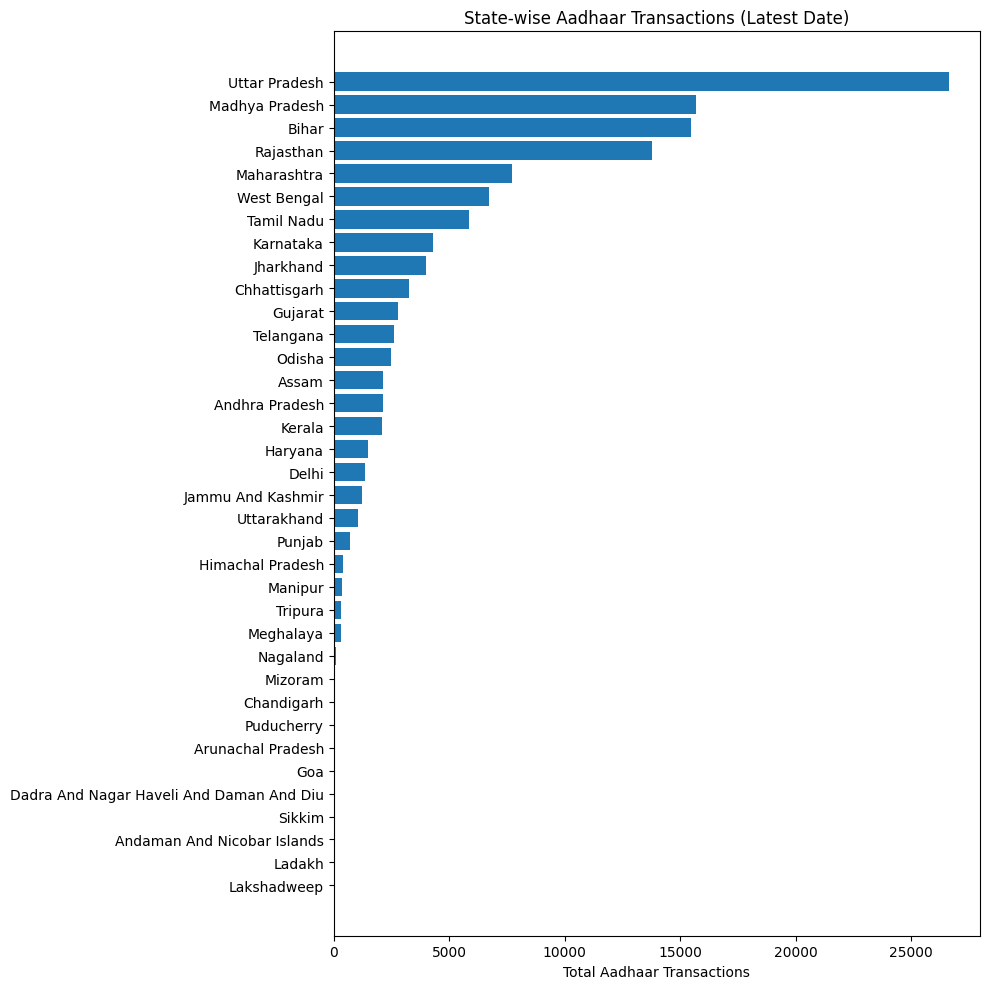

In [13]:
# State-level aggregation per day
state_daily = (
    df.groupby(['date', 'state'])
      .agg({
          'total_transactions': 'sum',
          'momentum': 'mean',
          'ADFS': 'mean',
          'ADFS_norm': 'mean'
      })
      .reset_index()
)

# Which states are generating the most Aadhaar load?

latest_date = state_daily['date'].max()

state_txn = (
    state_daily[state_daily['date'] == latest_date]
    .sort_values('total_transactions', ascending=True)
)

plt.figure(figsize=(10,10))
plt.barh(state_txn['state'], state_txn['total_transactions'])
plt.xlabel("Total Aadhaar Transactions")
plt.title("State-wise Aadhaar Transactions (Latest Date)")
plt.tight_layout()
plt.show()

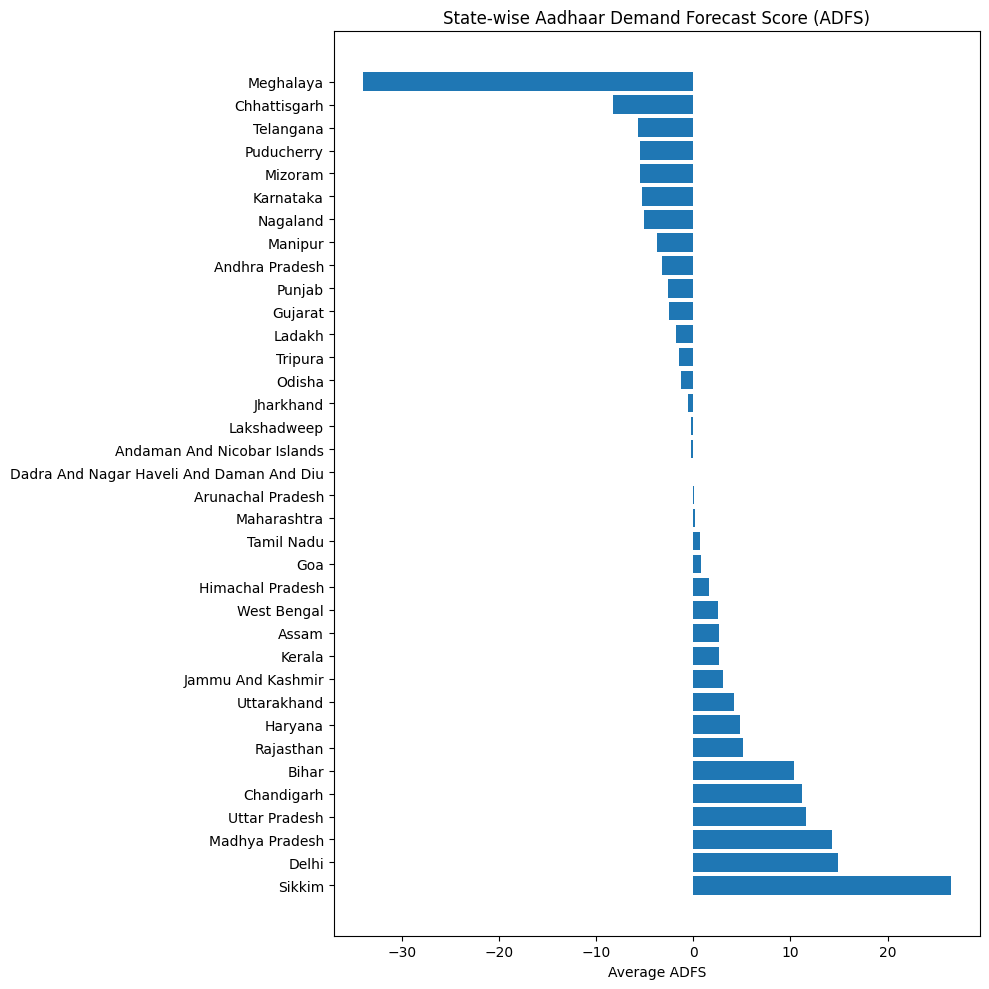

In [14]:
# Which states will face rising Aadhaar demand soon?

state_adfs = (
    state_daily[state_daily['date'] == latest_date]
    .sort_values('ADFS', ascending=False)
)

plt.figure(figsize=(10,10))
plt.barh(state_adfs['state'], state_adfs['ADFS'])
plt.xlabel("Average ADFS")
plt.title("State-wise Aadhaar Demand Forecast Score (ADFS)")
plt.tight_layout()
plt.show()

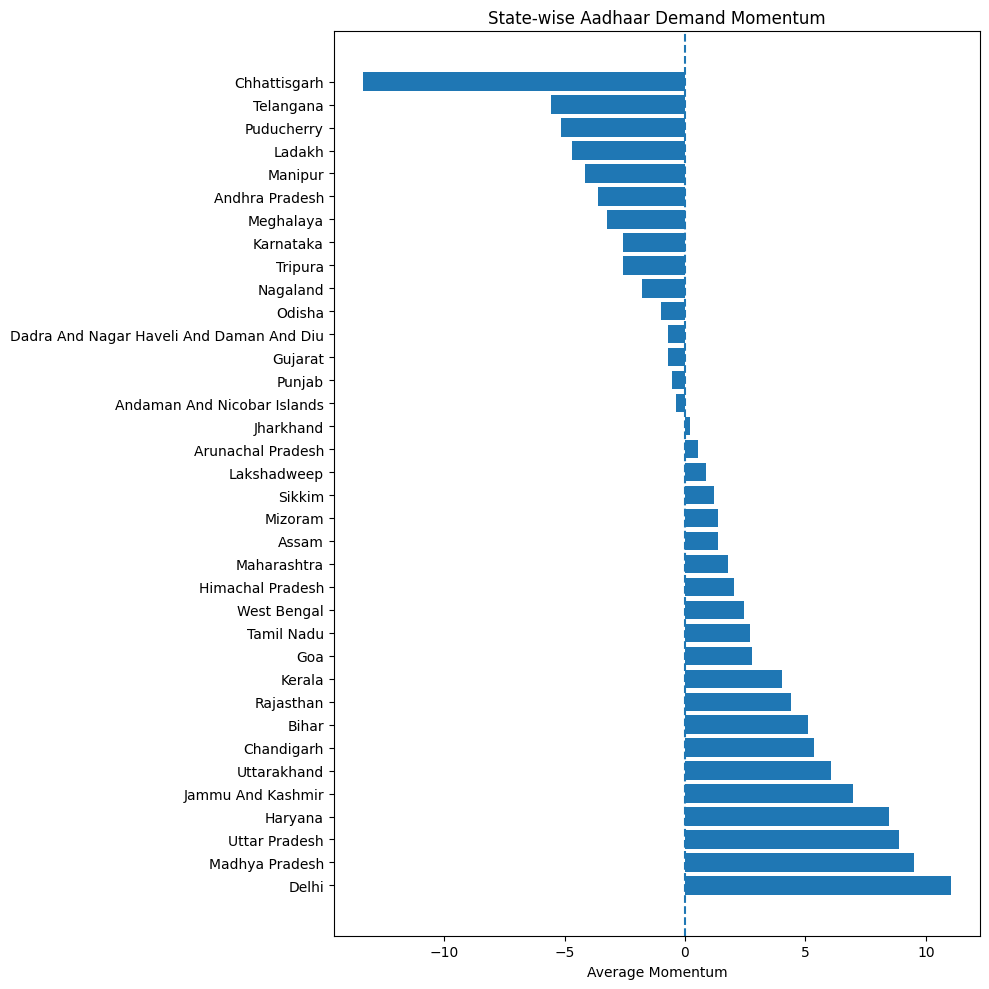

In [15]:
# Speed of demand change by state

state_momentum = (
    state_daily[state_daily['date'] == latest_date]
    .sort_values('momentum', ascending=False)
)

plt.figure(figsize=(10,10))
plt.barh(state_momentum['state'], state_momentum['momentum'])
plt.axvline(0, linestyle='--')
plt.xlabel("Average Momentum")
plt.title("State-wise Aadhaar Demand Momentum")
plt.tight_layout()
plt.show()


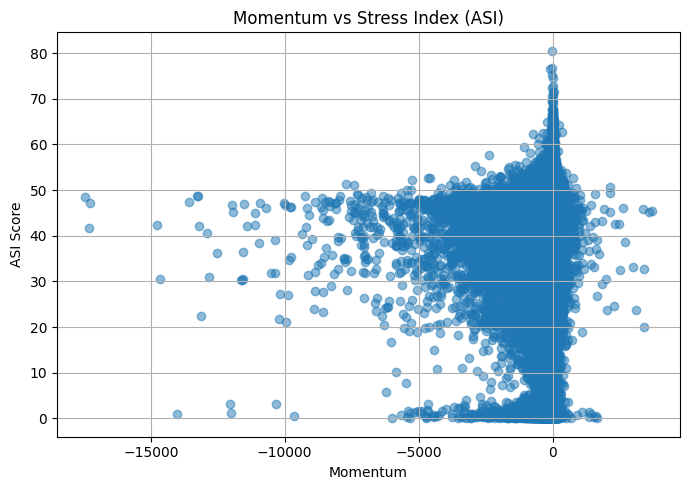

In [16]:
# Shows why ASI matters
plt.figure(figsize=(7,5))
plt.scatter(df['momentum'], asi['asi_score'], alpha=0.5)

plt.xlabel("Momentum")
plt.ylabel("ASI Score")
plt.title("Momentum vs Stress Index (ASI)")
plt.grid(True)
plt.tight_layout()
plt.show()


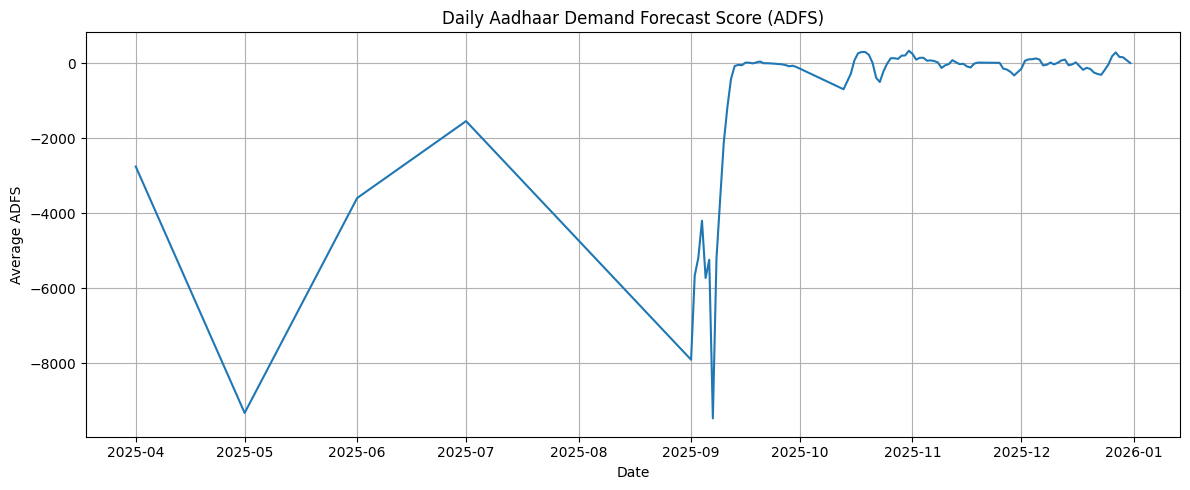

In [17]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.to_period('Q')

# Short-term Aadhaar demand evolution

daily_adfs = (
    df.groupby('date')['ADFS']
      .mean()
      .reset_index()
)

plt.figure(figsize=(12,5))
plt.plot(daily_adfs['date'], daily_adfs['ADFS'])

plt.xlabel("Date")
plt.ylabel("Average ADFS")
plt.title("Daily Aadhaar Demand Forecast Score (ADFS)")
plt.grid(True)
plt.tight_layout()
plt.show()

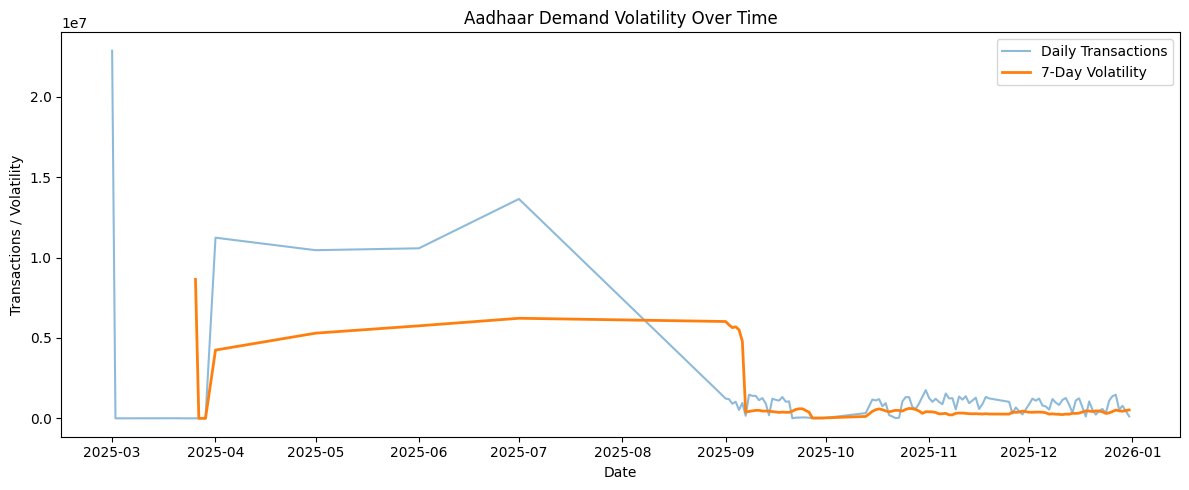

In [18]:
# Daily Transactions + Rolling Variability
daily = df.groupby('date')['total_transactions'].sum().reset_index()

daily['rolling_std_7'] = daily['total_transactions'].rolling(7).std()

plt.figure(figsize=(12,5))
plt.plot(daily['date'], daily['total_transactions'], label='Daily Transactions', alpha=0.5)
plt.plot(daily['date'], daily['rolling_std_7'], label='7-Day Volatility', linewidth=2)

plt.title("Aadhaar Demand Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Transactions / Volatility")
plt.legend()
plt.tight_layout()
plt.show()

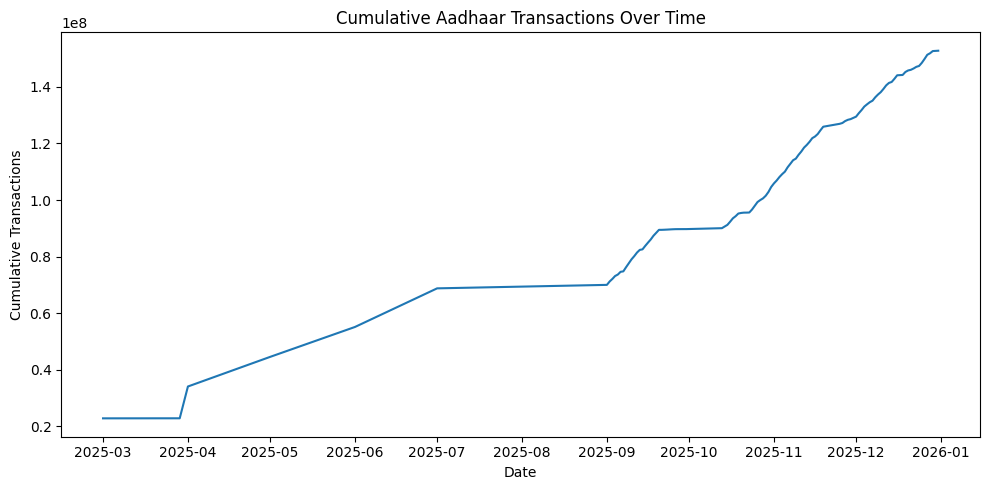

In [19]:
# iS DEMAND GROWING OR JUST FLUCTUATING?
daily['cumulative_txn'] = daily['total_transactions'].cumsum()

plt.figure(figsize=(10,5))
plt.plot(daily['date'], daily['cumulative_txn'])

plt.title("Cumulative Aadhaar Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Transactions")
plt.tight_layout()
plt.show()

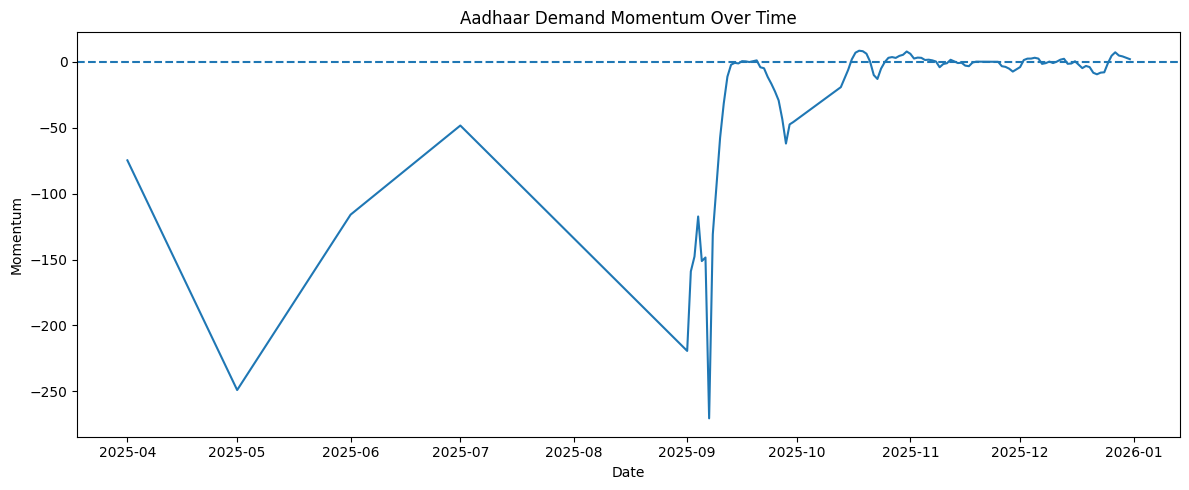

In [20]:
# WHEN DOES DEMAND ACCELERATE?
daily_momentum = df.groupby('date')['momentum'].mean().reset_index()

plt.figure(figsize=(12,5))
plt.plot(daily_momentum['date'], daily_momentum['momentum'])
plt.axhline(0, linestyle='--')

plt.title("Aadhaar Demand Momentum Over Time")
plt.xlabel("Date")
plt.ylabel("Momentum")
plt.tight_layout()
plt.show()

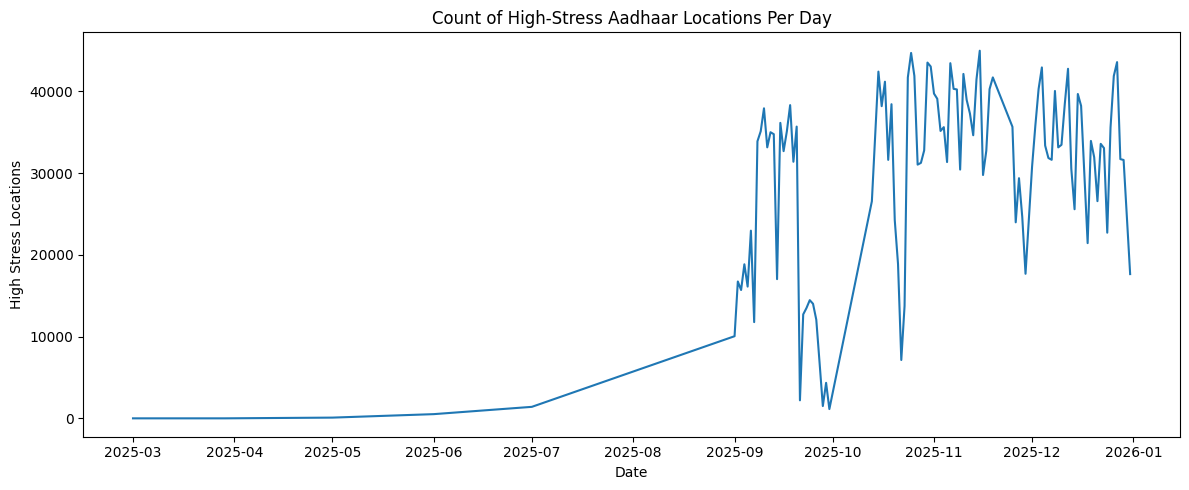

In [21]:
# HOW FREQUENT ARE HIGH-STRESS PERIODS?
df['high_stress'] = df['ADFS_norm'] >= 0.7

stress_days = df.groupby('date')['high_stress'].sum().reset_index()

plt.figure(figsize=(12,5))
plt.plot(stress_days['date'], stress_days['high_stress'])

plt.title("Count of High-Stress Aadhaar Locations Per Day")
plt.xlabel("Date")
plt.ylabel("High Stress Locations")
plt.tight_layout()
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_9264\883696813.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["adfs_growth"] = df["ADFS"].pct_change()


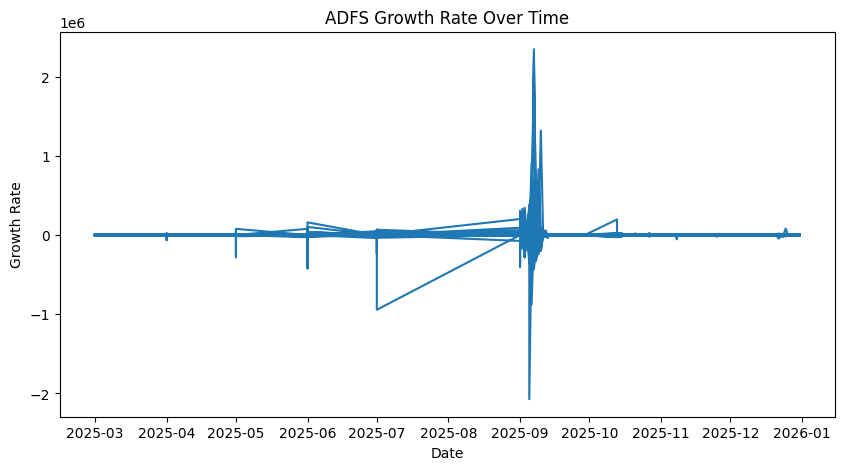

In [22]:
df["adfs_growth"] = df["ADFS"].pct_change()

plt.figure(figsize=(10,5))
plt.plot(df["date"], df["adfs_growth"])
plt.title("ADFS Growth Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Growth Rate")
plt.show()


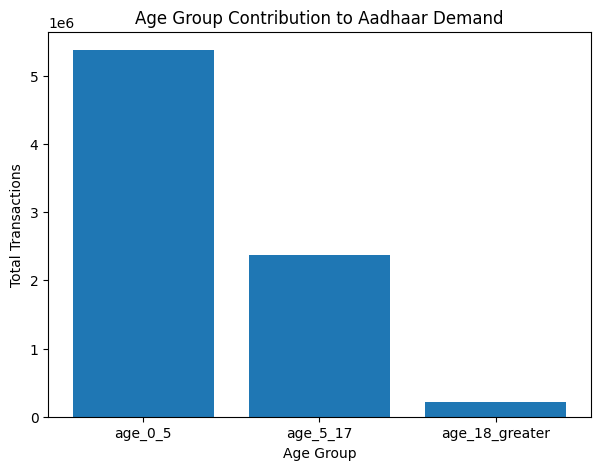

In [23]:
age_df = df[[
    "age_0_5", "age_5_17", "age_18_greater"
]].sum()

plt.figure(figsize=(7,5))
plt.bar(age_df.index, age_df.values)
plt.title("Age Group Contribution to Aadhaar Demand")
plt.xlabel("Age Group")
plt.ylabel("Total Transactions")
plt.show()


In [24]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


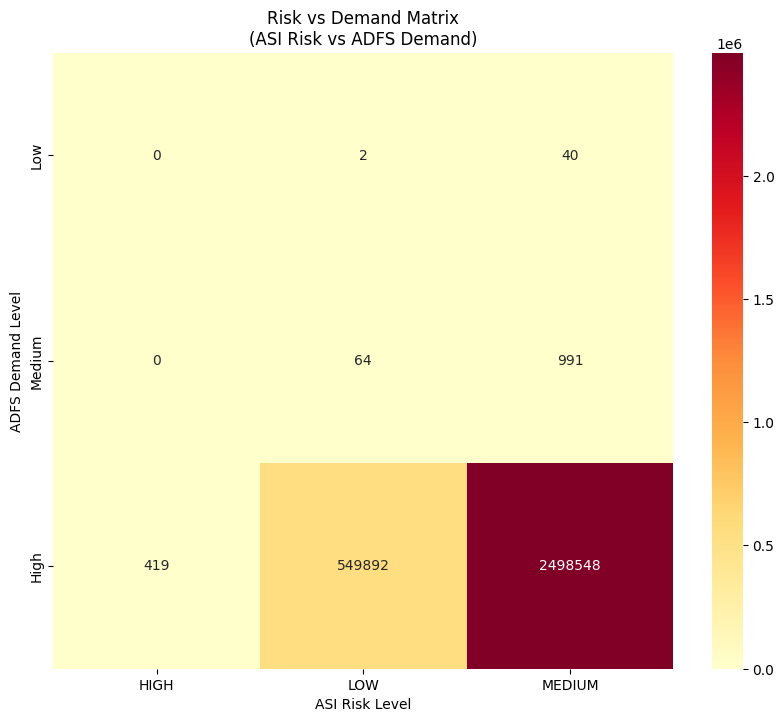

In [25]:
import seaborn as sns
# Create 2x2 matrix: ASI Risk vs ADFS Demand
plt.figure(figsize=(10, 8))

# Create categories
df['demand_level'] = pd.cut(df['ADFS_norm'], 
                            bins=[-1, 0.4, 0.7, 1], 
                            labels=['Low', 'Medium', 'High'])

# Count combinations
risk_demand_matrix = pd.crosstab(df['demand_level'], asi['asi_risk'])

sns.heatmap(risk_demand_matrix, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Risk vs Demand Matrix\n(ASI Risk vs ADFS Demand)')
plt.xlabel('ASI Risk Level')
plt.ylabel('ADFS Demand Level')
plt.show()

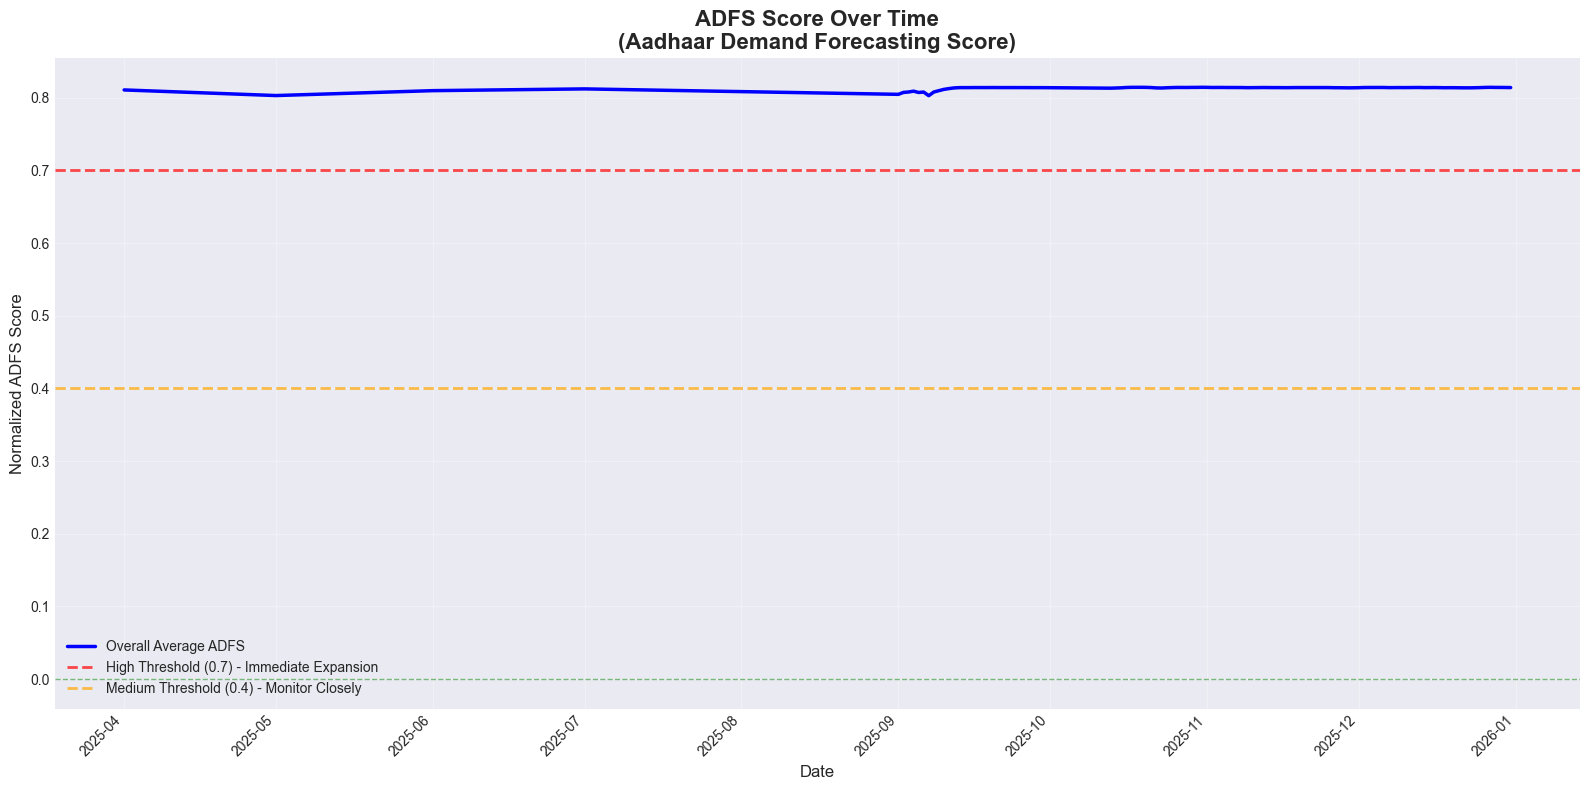

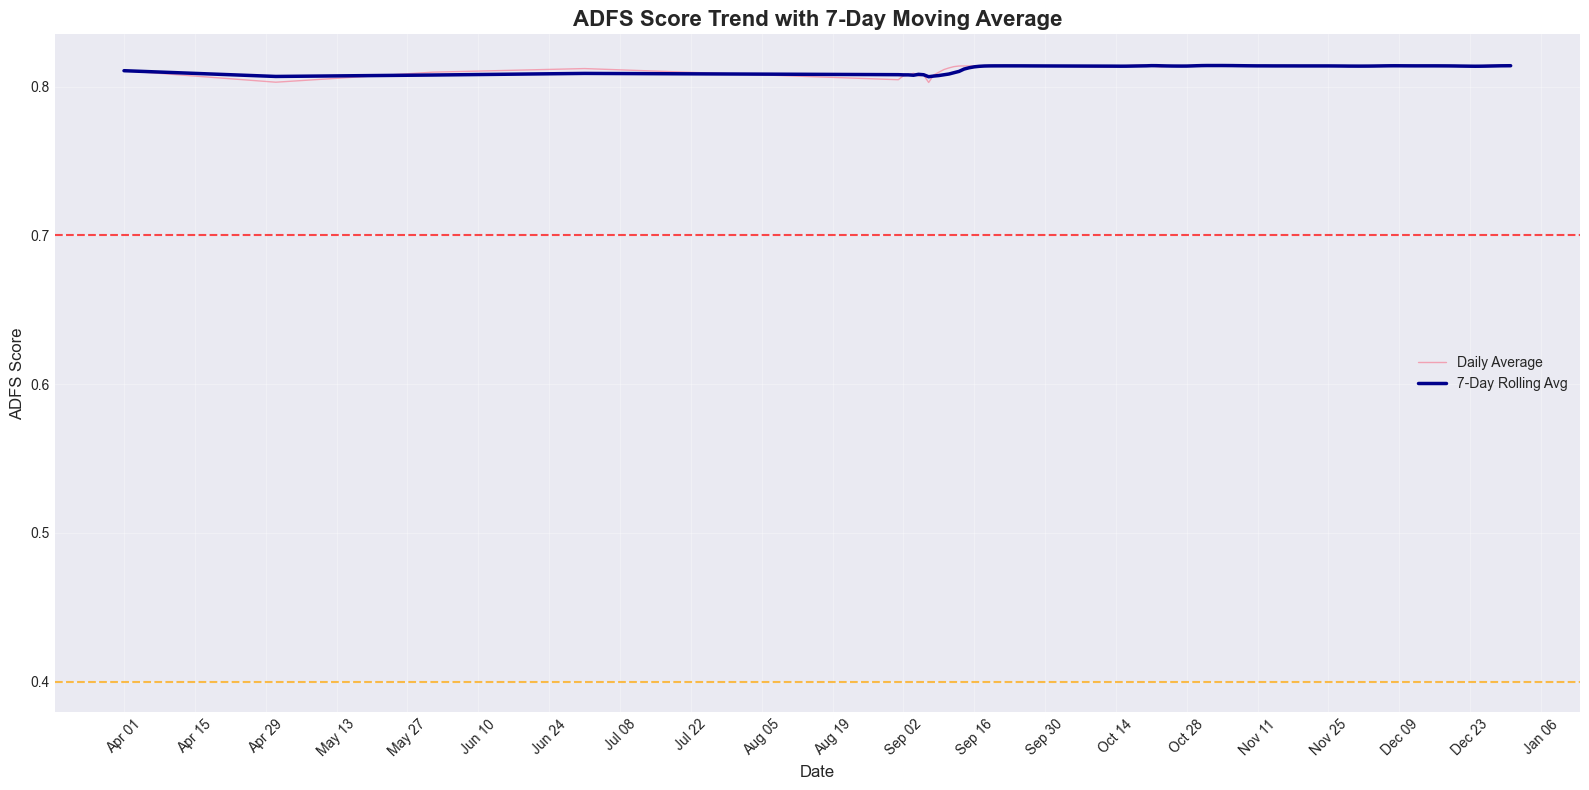

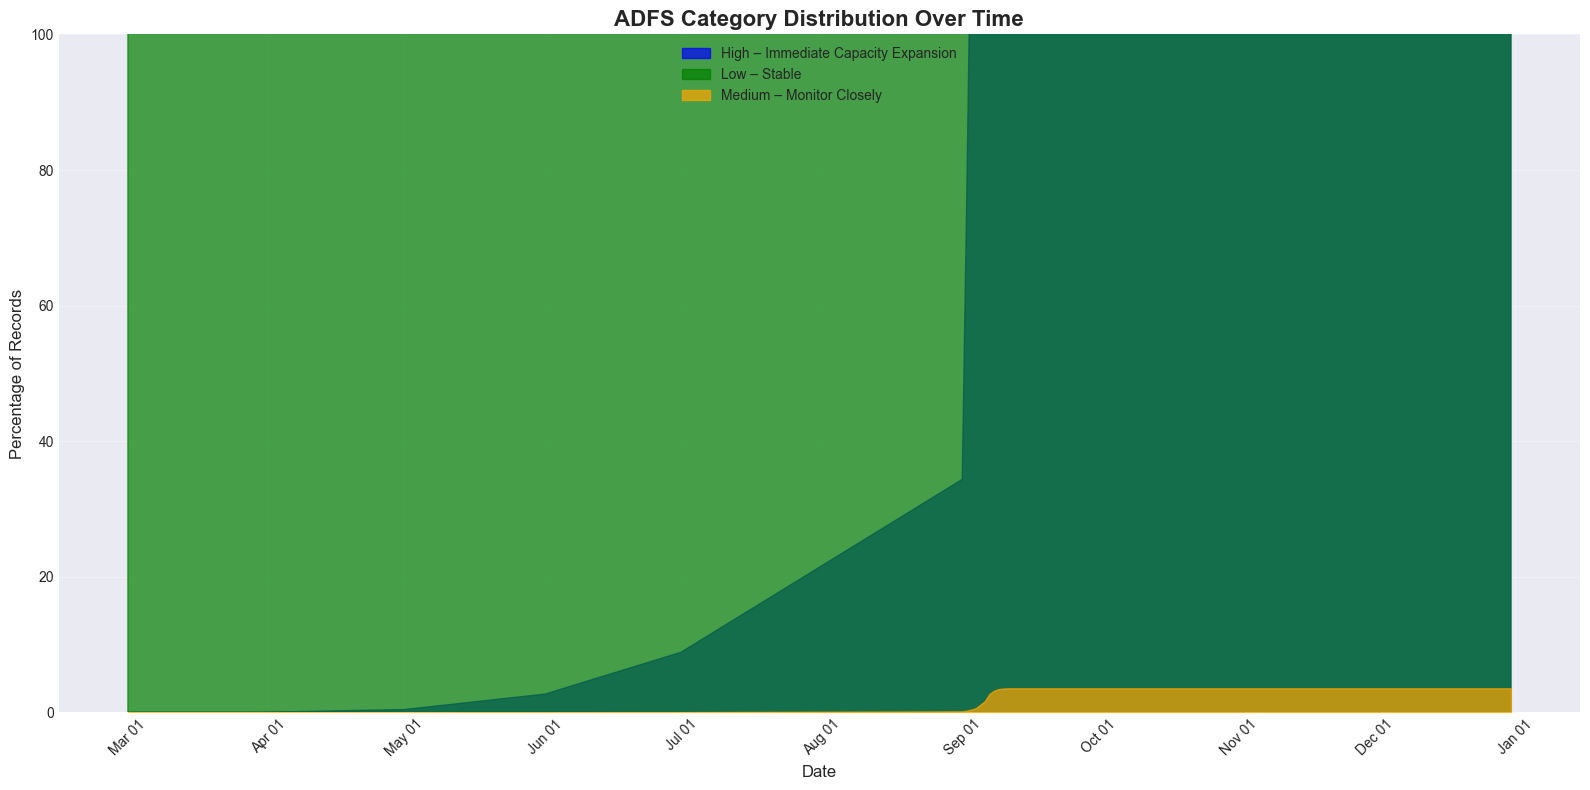

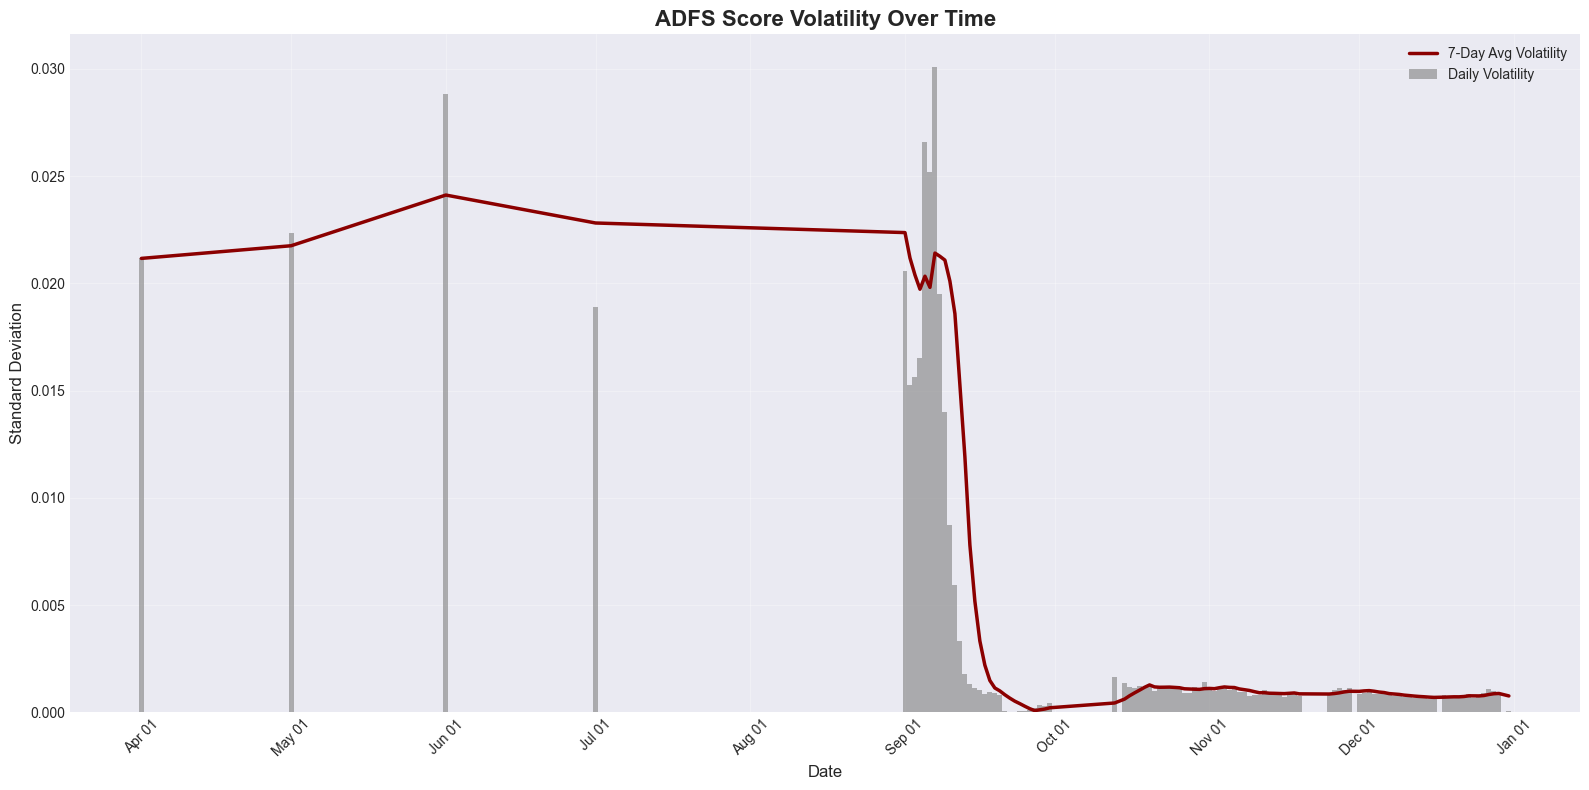

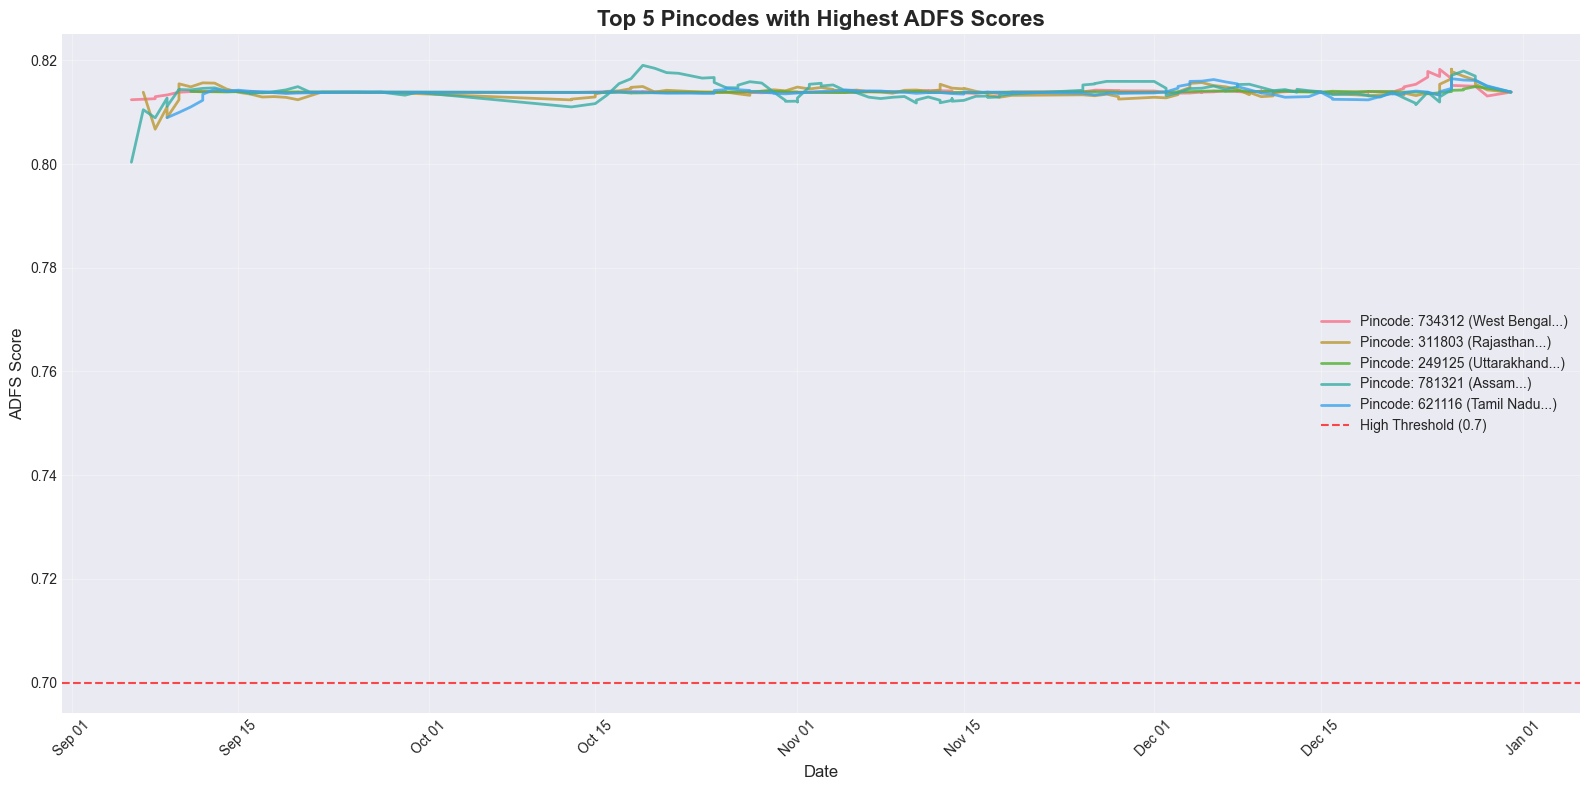

In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates as mdates

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. BASIC ADFS SCORE OVER TIME (All data)
plt.figure(figsize=(16, 8))

# Plot overall ADFS trend
df.groupby('date')['ADFS_norm'].mean().plot(linewidth=2.5, label='Overall Average ADFS', color='blue')

# Add thresholds
plt.axhline(y=0.7, color='red', linestyle='--', linewidth=2, alpha=0.7, 
            label='High Threshold (0.7) - Immediate Expansion')
plt.axhline(y=0.4, color='orange', linestyle='--', linewidth=2, alpha=0.7,
            label='Medium Threshold (0.4) - Monitor Closely')
plt.axhline(y=0, color='green', linestyle='--', linewidth=1, alpha=0.5)

# Formatting
plt.title('ADFS Score Over Time\n(Aadhaar Demand Forecasting Score)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized ADFS Score', fontsize=12)
plt.grid(True, alpha=0.3)

# Format x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Add legend
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

# 2. ADFS SCORE TREND WITH 7-DAY MOVING AVERAGE
plt.figure(figsize=(16, 8))

overall_avg = df.groupby('date')['ADFS_norm'].mean()
rolling_avg = overall_avg.rolling(window=7, min_periods=1).mean()

plt.plot(overall_avg.index, overall_avg.values, alpha=0.6, label='Daily Average', linewidth=1)
plt.plot(rolling_avg.index, rolling_avg.values, label='7-Day Rolling Avg', linewidth=2.5, color='darkblue')
plt.axhline(y=0.7, color='red', linestyle='--', alpha=0.7)
plt.axhline(y=0.4, color='orange', linestyle='--', alpha=0.7)

plt.title('ADFS Score Trend with 7-Day Moving Average', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('ADFS Score', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. ADFS CATEGORY DISTRIBUTION OVER TIME
plt.figure(figsize=(16, 8))

category_trends = df.groupby(['date', 'ADFS_category']).size().unstack(fill_value=0)

# Calculate percentages
category_percentages = category_trends.div(category_trends.sum(axis=1), axis=0) * 100

# Plot stacked area
colors = {'High – Immediate Capacity Expansion': 'blue', 
          'Medium – Monitor Closely': 'orange', 
          'Low – Stable': 'green'}

for category in category_percentages.columns:
    plt.fill_between(category_percentages.index, 0, category_percentages[category].cumsum(), 
                     label=category, alpha=0.7, color=colors[category])

plt.title('ADFS Category Distribution Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percentage of Records', fontsize=12)
plt.ylim(0, 100)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. ADFS SCORE VOLATILITY OVER TIME
plt.figure(figsize=(16, 8))

volatility = df.groupby('date')['ADFS_norm'].std()
volatility_rolling = volatility.rolling(window=7, min_periods=1).mean()

plt.bar(volatility.index, volatility.values, alpha=0.6, width=1, color='gray', label='Daily Volatility')
plt.plot(volatility_rolling.index, volatility_rolling.values, 
         label='7-Day Avg Volatility', linewidth=2.5, color='darkred')

plt.title('ADFS Score Volatility Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Standard Deviation', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. TOP 5 PINCODES WITH HIGHEST ADFS SCORES
plt.figure(figsize=(16, 8))

# Get top 5 pincodes by average ADFS
top_pincodes = df.groupby('pincode')['ADFS_norm'].mean().nlargest(5).index

for pincode in top_pincodes:
    pincode_data = df[df['pincode'] == pincode].sort_values('date')
    if not pincode_data.empty:
        state_name = pincode_data['state'].iloc[0] if 'state' in pincode_data.columns else 'Unknown'
        label = f'Pincode: {pincode} ({state_name[:15]}...)'
        plt.plot(pincode_data['date'], pincode_data['ADFS_norm'], 
                label=label, linewidth=2, alpha=0.8)

plt.axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='High Threshold (0.7)')
plt.title('Top 5 Pincodes with Highest ADFS Scores', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('ADFS Score', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load shapefiles
states_gdf = gpd.read_file("states\Admin2.shp")
districts_gdf = gpd.read_file("Districts-Census_2011\\2011_Dist.shp")

In [28]:
print(states_gdf.columns)
print(districts_gdf.columns)

Index(['ST_NM', 'geometry'], dtype='object')
Index(['DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD', 'censuscode',
       'geometry'],
      dtype='object')


In [29]:
states_map = states_gdf.merge(
    state_adfs,
    left_on="ST_NM",
    right_on="state",
    how="left"
)


In [30]:
district_adfs = df.groupby(['state', 'district']).agg({
    'ADFS': 'mean',
    'ADFS_norm': 'mean',
    'total_transactions': 'sum',
    'pincode': 'nunique'
}).reset_index()

districts_map = districts_gdf.merge(
    district_adfs,
    left_on=["ST_NM", "DISTRICT"],
    right_on=["state", "district"],
    how="left"
)

In [31]:
states_map["ADFS"] = states_map["ADFS"].fillna(0)
districts_map["ADFS"] = districts_map["ADFS"].fillna(0)


<Figure size 1200x1200 with 0 Axes>

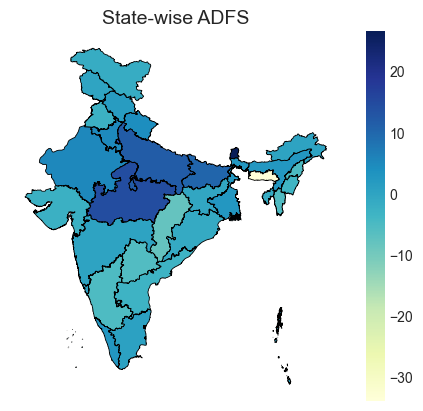

In [32]:
plt.figure(figsize=(12, 12))
states_map.plot(
    column="ADFS",
    cmap="YlGnBu",
    linewidth=0.6,
    edgecolor="black",
    legend=True
)

plt.title("State-wise ADFS", fontsize=14)
plt.axis("off")
plt.show()


<Figure size 1400x1400 with 0 Axes>

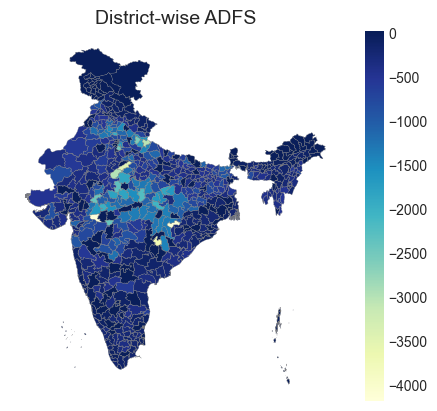

In [33]:
plt.figure(figsize=(14, 14))
districts_map.plot(
    column="ADFS",
    cmap="YlGnBu",
    linewidth=0.2,
    edgecolor="grey",
    legend=True
)

plt.title("District-wise ADFS", fontsize=14)
plt.axis("off")
plt.show()


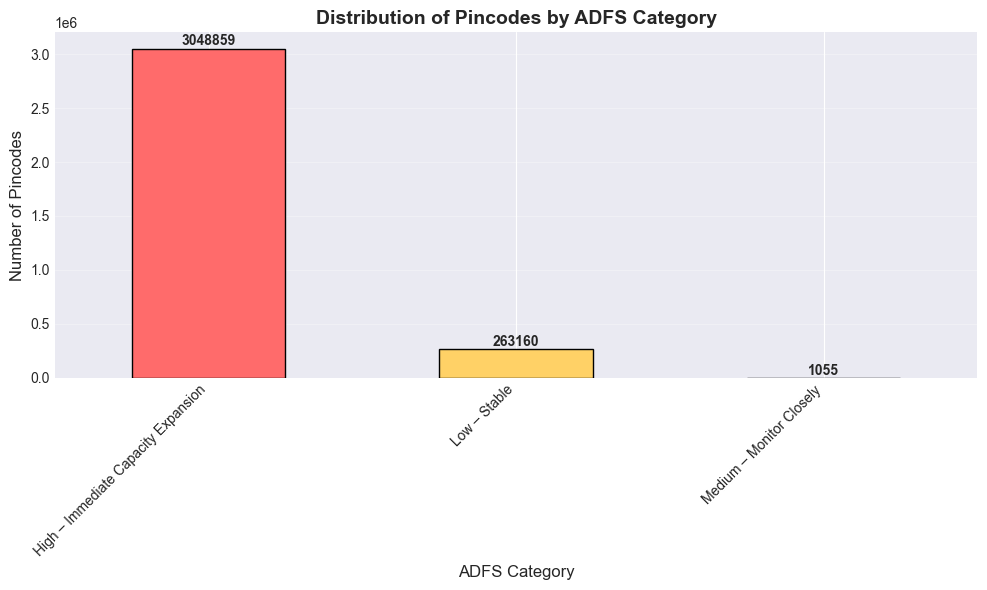

In [35]:
# Count of pincodes in each ADFS category
category_counts = df['ADFS_category'].value_counts()

# Create bar chart
plt.figure(figsize=(10, 6))
colors = ['#FF6B6B', '#FFD166', '#06D6A0']  # Red, Yellow, Green
category_counts.plot(kind='bar', color=colors, edgecolor='black')

plt.title('Distribution of Pincodes by ADFS Category', fontsize=14, fontweight='bold')
plt.xlabel('ADFS Category', fontsize=12)
plt.ylabel('Number of Pincodes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(category_counts):
    plt.text(i, v + max(category_counts)*0.01, str(v), 
             ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

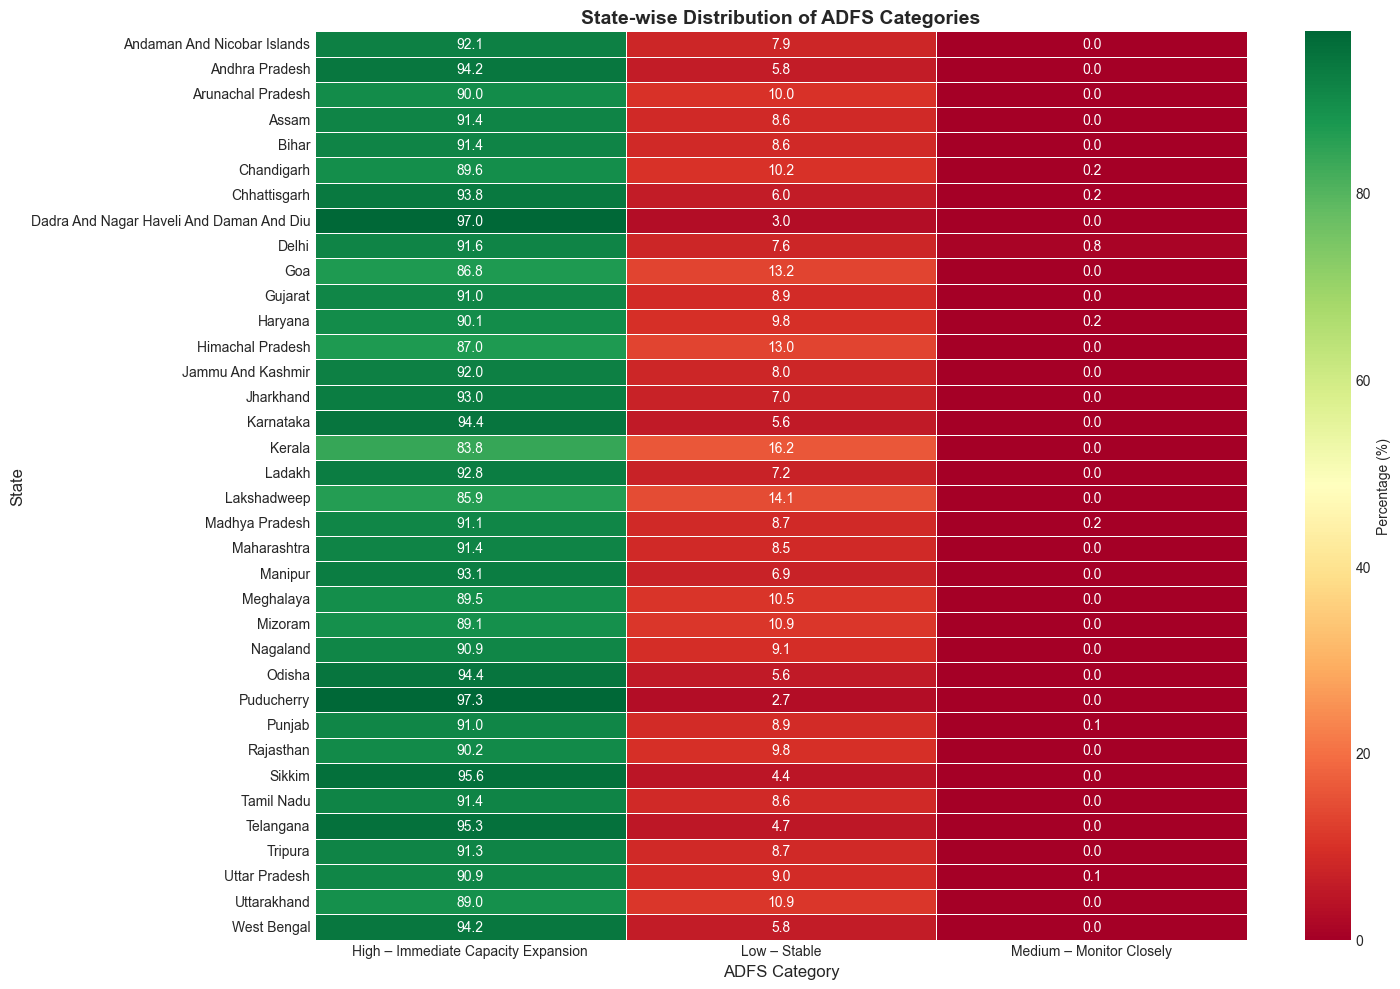

In [40]:
# Create state-level aggregation
state_category = df.groupby(['state', 'ADFS_category']).size().unstack(fill_value=0)

# Calculate percentages
state_percentage = state_category.div(state_category.sum(axis=1), axis=0) * 100

# Create heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(state_percentage, 
            cmap='RdYlGn',
            annot=True, 
            fmt='.1f',
            linewidths=0.5,
            cbar_kws={'label': 'Percentage (%)'})

plt.title('State-wise Distribution of ADFS Categories', fontsize=14, fontweight='bold')
plt.xlabel('ADFS Category', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_9264\2175544038.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_category = df.groupby([pd.Grouper(key='date', freq='M'), 'ADFS_category']).size().unstack(fill_value=0)


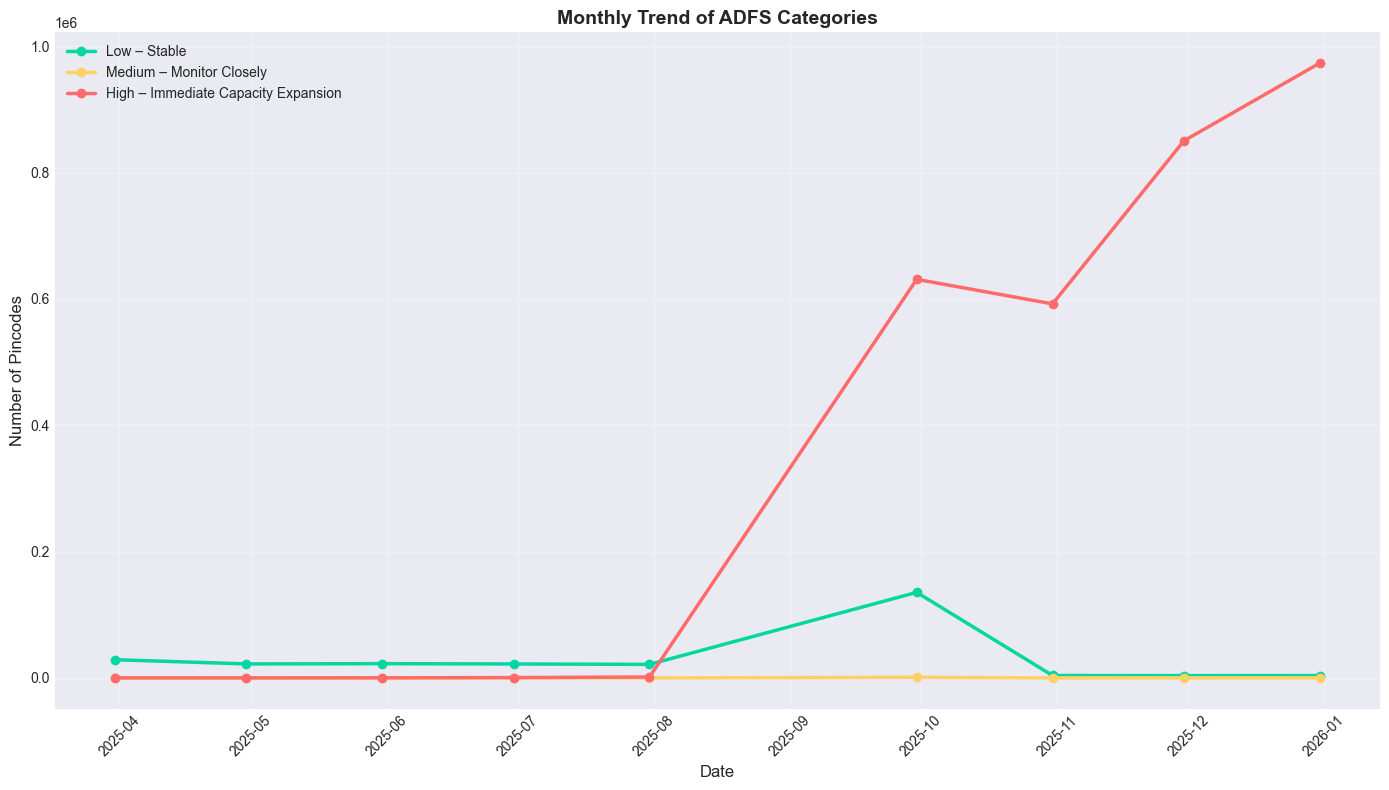

In [38]:
# Convert date to datetime if not already done
df['date'] = pd.to_datetime(df['date'])

# Group by month and category
monthly_category = df.groupby([pd.Grouper(key='date', freq='M'), 'ADFS_category']).size().unstack(fill_value=0)

# Create line plot
plt.figure(figsize=(14, 8))
colors = ['#06D6A0', '#FFD166', '#FF6B6B']  # Green, Yellow, Red (Low, Medium, High)

for i, category in enumerate(['Low – Stable', 'Medium – Monitor Closely', 'High – Immediate Capacity Expansion']):
    if category in monthly_category.columns:
        plt.plot(monthly_category.index, monthly_category[category], 
                 label=category, color=colors[i], linewidth=2.5, marker='o')

plt.title('Monthly Trend of ADFS Categories', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Pincodes', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

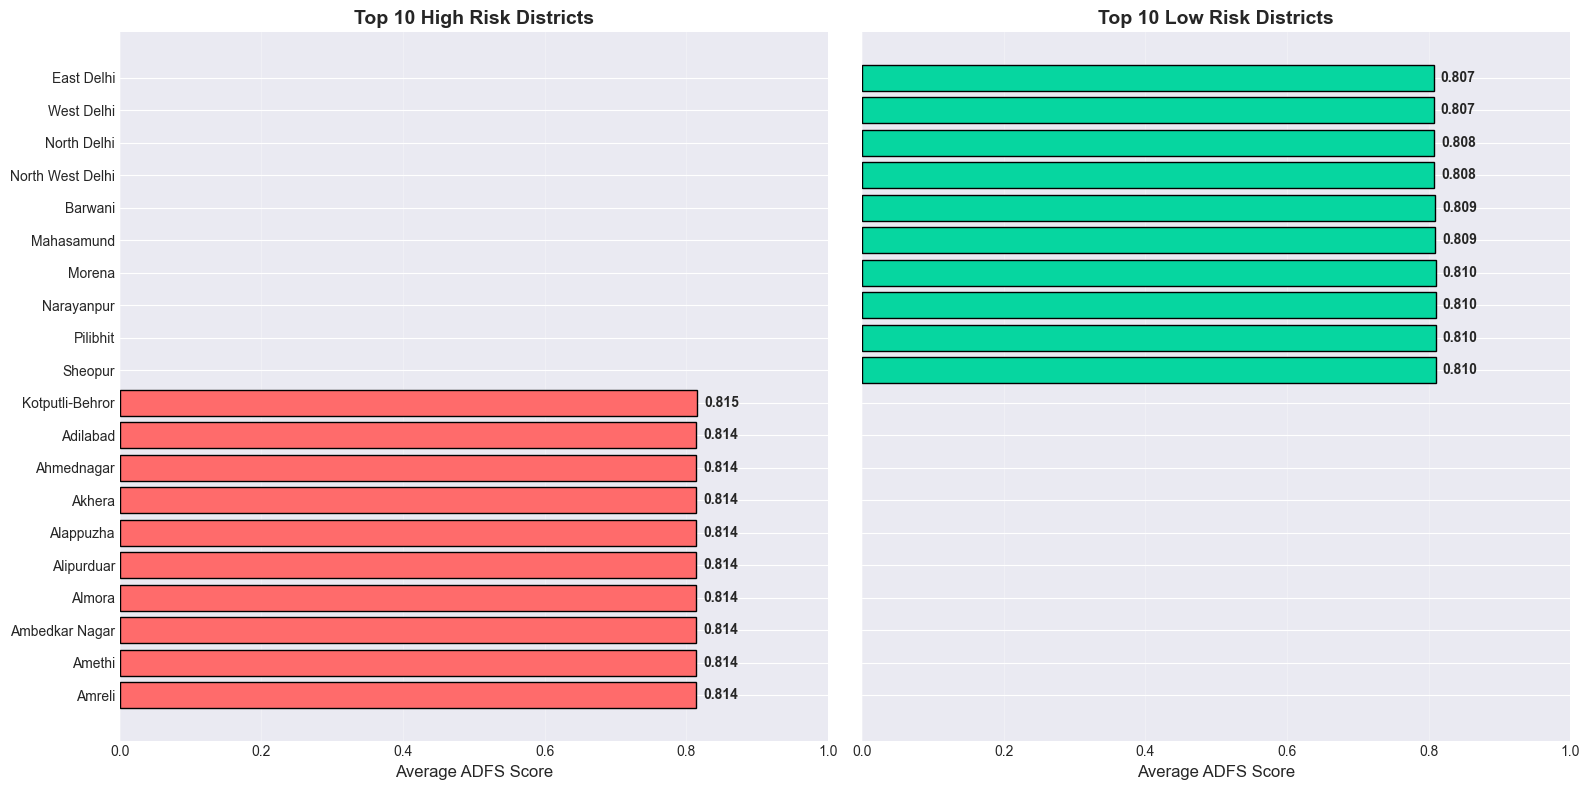

In [45]:
# Calculate district averages
district_avg = df.groupby('district').agg({
    'ADFS_norm': 'mean',
    'total_transactions': 'sum',
    'pincode': 'count'
}).round(3)

district_avg = district_avg.rename(columns={'pincode': 'num_pincodes'})

# Get top 10 highest risk districts
top_10_high = district_avg.nlargest(10, 'ADFS_norm')

# Get top 10 lowest risk districts
top_10_low = district_avg.nsmallest(10, 'ADFS_norm')

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# High risk districts
bars1 = ax1.barh(top_10_high.index[::-1], top_10_high['ADFS_norm'][::-1], 
                color='#FF6B6B', edgecolor='black')
ax1.set_title('Top 10 High Risk Districts', fontsize=14, fontweight='bold')
ax1.set_xlabel('Average ADFS Score', fontsize=12)
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3)

# Add values on bars
for i, (bar, score) in enumerate(zip(bars1, top_10_high['ADFS_norm'][::-1])):
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{score:.3f}', va='center', fontweight='bold')

# Low risk districts
bars2 = ax2.barh(top_10_low.index[::-1], top_10_low['ADFS_norm'][::-1], 
                color='#06D6A0', edgecolor='black')
ax2.set_title('Top 10 Low Risk Districts', fontsize=14, fontweight='bold')
ax2.set_xlabel('Average ADFS Score', fontsize=12)
ax2.set_xlim(0, 1)
ax2.grid(axis='x', alpha=0.3)

# Add values on bars
for i, (bar, score) in enumerate(zip(bars2, top_10_low['ADFS_norm'][::-1])):
    ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{score:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

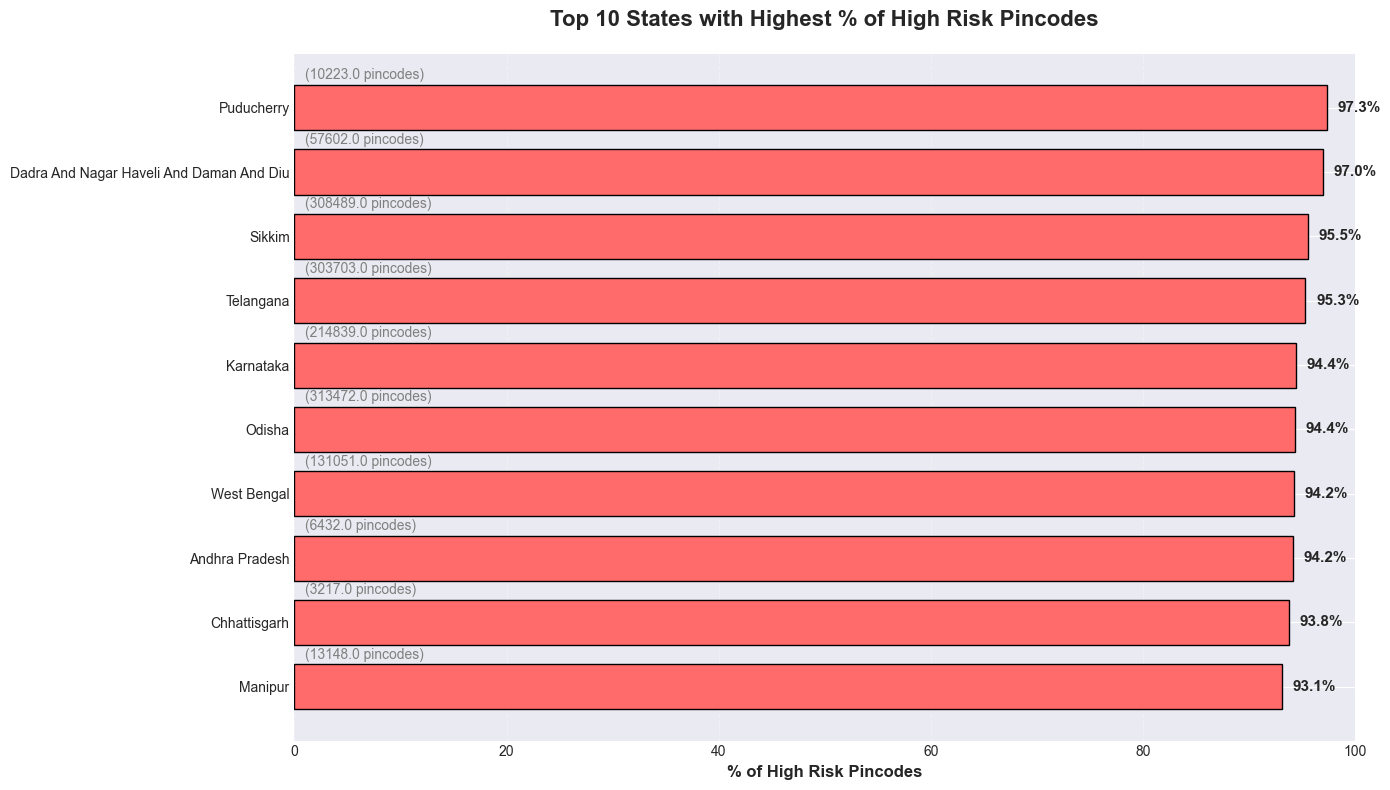


TOP 10 STATES BY % OF HIGH RISK PINCODES
Rank  State                                    High Risk %     Total Pincodes 
------------------------------------------------------------------------------------------
1     Puducherry                               97.3            13148.0        
2     Dadra And Nagar Haveli And Daman And Diu 97.0            3217.0         
3     Sikkim                                   95.5            6432.0         
4     Telangana                                95.3            131051.0       
5     Karnataka                                94.4            313472.0       
6     Odisha                                   94.4            214839.0       
7     West Bengal                              94.2            303703.0       
8     Andhra Pradesh                           94.2            308489.0       
9     Chhattisgarh                             93.8            57602.0        
10    Manipur                                  93.1            10223.0       

In [56]:
# Calculate state-level high risk percentage
df['date'] = pd.to_datetime(df['date'])

# Calculate percentage of high risk pincodes per state
state_high_risk = df.groupby('state').agg({
    'ADFS_category': lambda x: (x == 'High – Immediate Capacity Expansion').mean() * 100,
    'pincode': 'count'
}).round(2)

state_high_risk = state_high_risk.rename(columns={
    'ADFS_category': 'percent_high_risk',
    'pincode': 'total_pincodes'
})

# Sort by percentage of high risk (descending)
state_high_risk = state_high_risk.sort_values('percent_high_risk', ascending=False)

# Get top N states (you can change this number)
top_n = 10
top_states = state_high_risk.head(top_n)

# Create the visualization
plt.figure(figsize=(14, 8))

# Create horizontal bar chart (highest at top)
bars = plt.barh(top_states.index[::-1], top_states['percent_high_risk'][::-1], 
                color='#FF6B6B', edgecolor='black', height=0.7)

# Customize appearance
plt.title(f'Top {top_n} States with Highest % of High Risk Pincodes', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('% of High Risk Pincodes', fontsize=12, fontweight='bold')
plt.xlim(0, 100)
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add percentage values on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}%', 
             va='center', 
             fontweight='bold',
             fontsize=11)

# Add total pincodes as text on the left
for i, (state, row) in enumerate(top_states.iterrows()):
    plt.text(1, i + 0.5, f"({row['total_pincodes']} pincodes)", 
             va='center', 
             fontsize=10,
             color='gray')

plt.tight_layout()
plt.show()

# Display data table
print("\n" + "="*90)
print(f"TOP {top_n} STATES BY % OF HIGH RISK PINCODES")
print("="*90)
print(f"{'Rank':<5} {'State':<40} {'High Risk %':<15} {'Total Pincodes':<15}")
print("-"*90)

for i, (state, row) in enumerate(top_states.iterrows(), 1):
    print(f"{i:<5} {state:<40} {row['percent_high_risk']:<15.1f} {row['total_pincodes']:<15}")

print("="*90)

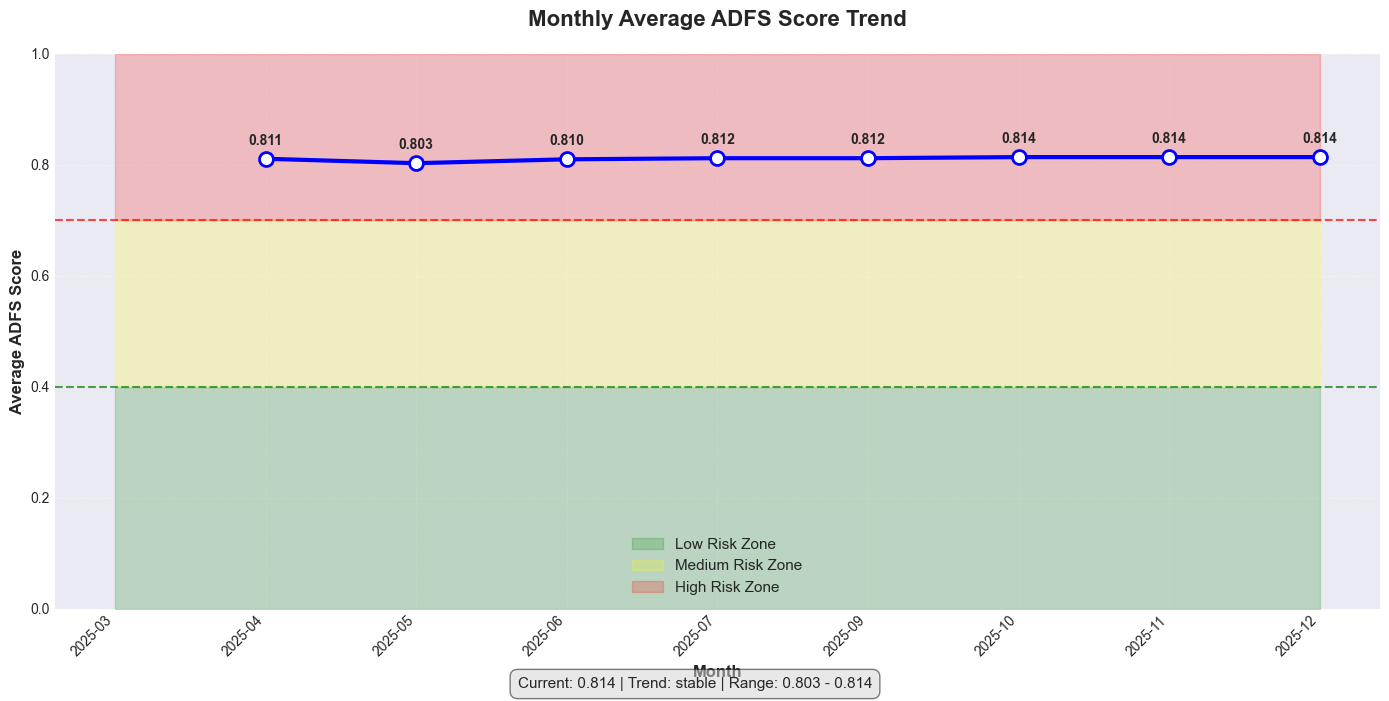

In [53]:
# Convert date and extract month-year
df['date'] = pd.to_datetime(df['date'])
df['month_year'] = df['date'].dt.to_period('M').astype(str)

# Calculate monthly average ADFS
monthly_adfs = df.groupby('month_year')['ADFS_norm'].mean().round(3)

# Create the plot
plt.figure(figsize=(14, 7))

# Plot the line
plt.plot(monthly_adfs.index, monthly_adfs.values, 
         marker='o', linewidth=3, color='blue', markersize=10, 
         markerfacecolor='white', markeredgewidth=2)

# Add shaded risk zones
plt.fill_between(monthly_adfs.index, 0, 0.4, alpha=0.2, color='green', label='Low Risk Zone')
plt.fill_between(monthly_adfs.index, 0.4, 0.7, alpha=0.2, color='yellow', label='Medium Risk Zone')
plt.fill_between(monthly_adfs.index, 0.7, 1.0, alpha=0.2, color='red', label='High Risk Zone')

# Add threshold lines
plt.axhline(y=0.4, color='green', linestyle='--', alpha=0.7, linewidth=1.5)
plt.axhline(y=0.7, color='red', linestyle='--', alpha=0.7, linewidth=1.5)

# Add labels and text
for i, (month, value) in enumerate(zip(monthly_adfs.index, monthly_adfs.values)):
    plt.text(i, value + 0.02, f'{value:.3f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Customize the plot
plt.title('Monthly Average ADFS Score Trend', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Average ADFS Score', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(0, 1)
plt.legend(loc='best', fontsize=11)

# Add summary statistics
last_month = monthly_adfs.iloc[-1]
first_month = monthly_adfs.iloc[0]
trend = "increasing" if last_month > first_month else "decreasing" if last_month < first_month else "stable"

summary_text = f"Current: {last_month:.3f} | Trend: {trend} | Range: {monthly_adfs.min():.3f} - {monthly_adfs.max():.3f}"
plt.figtext(0.5, 0.01, summary_text, ha='center', fontsize=11, 
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.5))

plt.tight_layout()
plt.show()